### Problem 1
Implement serial test and apply to a `samples`

In [1]:
import numpy as np
from scipy.stats import chi2

def rng(m=2**32, a=1103515245, c=12345):
    rng.current = (a * rng.current + c) % m
    return rng.current / m
rng.current = 1
samples = [rng() for _ in range(1000)]

def serial_test(samples, k=10):
    n = len(samples)
    expected_frequency = (n - 1) / (k * k)
    
    # k x k matrix to count the frequency of pairs
    frequency_matrix = np.zeros((k, k), dtype=int)
    intervals = np.floor(np.array(samples) * k).astype(int)
    
    for i in range(n - 1):
        x = intervals[i]
        y = intervals[i + 1]
        frequency_matrix[x, y] += 1
    
    chi_squared = 0
    for i in range(k):
        for j in range(k):
            observed = frequency_matrix[i, j]
            chi_squared += (observed - expected_frequency) ** 2 / expected_frequency
    
    degrees_of_freedom = k * k - 1
    p_value = 1 - chi2.cdf(chi_squared, degrees_of_freedom)
    return chi_squared, p_value

# Applying the test to our sample
chi_squared, p_value = serial_test(samples)
print(f"Chi-squared statistic: {chi_squared}")
print(f"P-value: {p_value}")



Chi-squared statistic: 95.19419419419421
P-value: 0.5895775741949776


### Problem 2*
Implement permutation test and apply to a `samples`

In [2]:

from itertools import permutations
rng.current = 1

n = 10 
d = 3     
samples = [rng() for _ in range(n * d)]

def permutation_test(samples, d):
    # All possible permutations for length d
    all_perms = list(permutations(range(d)))
    perm_counts = {perm: 0 for perm in all_perms}
    series = np.array(samples).reshape(-1, d)
    
    # Frequency of each permutation
    for ser in series:
        sorted_indices = tuple(np.argsort(ser))
        perm_counts[sorted_indices] += 1
    
    # Observed and expected frequencies
    f_obs = np.array(list(perm_counts.values()))
    f_exp = np.full(len(f_obs), len(series) / len(all_perms))
    
    chi_squared = np.sum((f_obs - f_exp) ** 2 / f_exp)
    degrees_of_freedom = len(all_perms) - 1
    p_value = 1 - chi2.cdf(chi_squared, degrees_of_freedom)
    
    return chi_squared, p_value

chi_squared, p_value = permutation_test(samples, d)
print(f"Chi-squared statistic: {chi_squared}")
print(f"P-value: {p_value}")


Chi-squared statistic: 2.0000000000000004
P-value: 0.8491450360846096


### Problem 3

Provide a statistical test to show that `rng_bad` has problems but `rng_good` does not.

In [3]:

def rng_bad(m=2**31, a=65539, c=0):
    rng_bad.current = (a * rng_bad.current + c) % m
    return rng_bad.current / m
rng_bad.current = 1
rng.current = 1
samples_good = [rng() for _ in range(1000)]
samples_bad = [rng_bad() for _ in range(1000)]
# Serial test on both samples
serial_good = serial_test(samples_good)
serial_bad = serial_test(samples_bad)

print(f"Serial test for rng_good: chi-squared={serial_good[0]}, p-value={serial_good[1]}")
print(f"Serial test for rng_bad: chi-squared={serial_bad[0]}, p-value={serial_bad[1]}")

Serial test for rng_good: chi-squared=95.19419419419421, p-value=0.5895775741949776
Serial test for rng_bad: chi-squared=119.41841841841838, p-value=0.07949705064002277


### Problem 4
Simulate a sample of 1000 from a discrete distribution on a set of digits $0, 1, 2, \ldots, 9$ with weights $0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2$. Construct a histogram from the sample. Optimise the algorithm by ordering the weights.

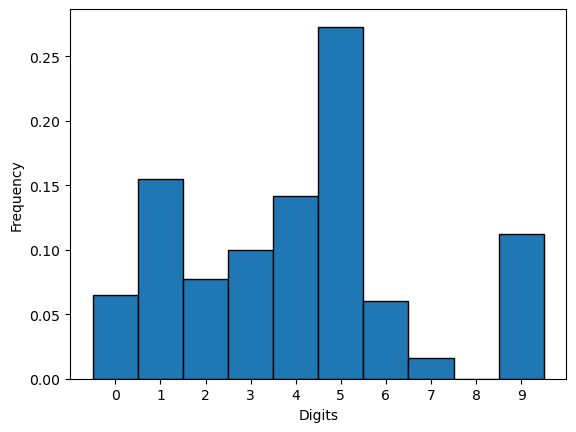

In [4]:
import matplotlib.pyplot as plt

digits = np.arange(10)
weights = np.array([0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2])

# Normalizing the weights
weights /= np.sum(weights)

# Sorting the weights and digits
sorted_indices = np.argsort(weights)[::-1]
sorted_weights = weights[sorted_indices]
sorted_digits = digits[sorted_indices]
sample = np.random.choice(sorted_digits, size=1000, p=sorted_weights)

# Histogram
plt.hist(sample, bins=np.arange(11) - 0.5, edgecolor='black', density=True)
plt.xticks(digits)
plt.xlabel('Digits')
plt.ylabel('Frequency')
plt.show()

### Problem 5
Simulate a sample of size 1000 from the distribution $\operatorname{Exp}(\lambda)$ using the Inverse transform method. Construct a sample histogram and an accurate plot of the distribution density.

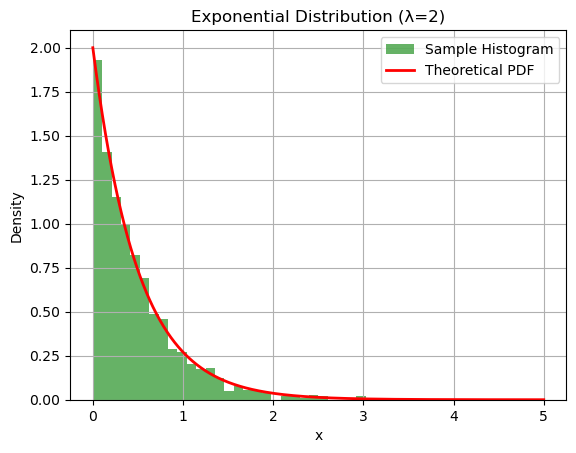

In [5]:
from scipy.stats import expon

# Parameters of distribution
lambda_ = 2
sample_size = 1000

def inverse_transform_exponential(lambda_, size):
    U = np.random.uniform(0, 1, size)
    # Inverse Cumulative Distribution Function(CDF) of our distribution
    samples = -np.log(1 - U) / lambda_
    return samples

samples = inverse_transform_exponential(lambda_, sample_size)

# Histogram of the sample
plt.hist(samples, bins=30, density=True, alpha=0.6, color='g', label='Sample Histogram')

# Theoretical Probability Density Function(PDF) of the exponential distribution
x = np.linspace(0, 5, 1000)
pdf = expon.pdf(x, scale=1/lambda_) 
plt.plot(x, pdf, 'r-', lw=2, label='Theoretical PDF')

plt.xlabel('x')
plt.ylabel('Density')
plt.title(f'Exponential Distribution (λ={lambda_})')
plt.legend()
plt.grid(True)
plt.show()

### Problem 6
Justify (orally) that the accept-reject method really samples from the required distribution. Simulate $1000$ points from the distribution with density $e^xcos^2x \cdot \mathbb{I}_{[-\frac\pi2, \frac\pi2]}$. Plot the sampled histogram on the sample and compare it with the plot of the exact density function.

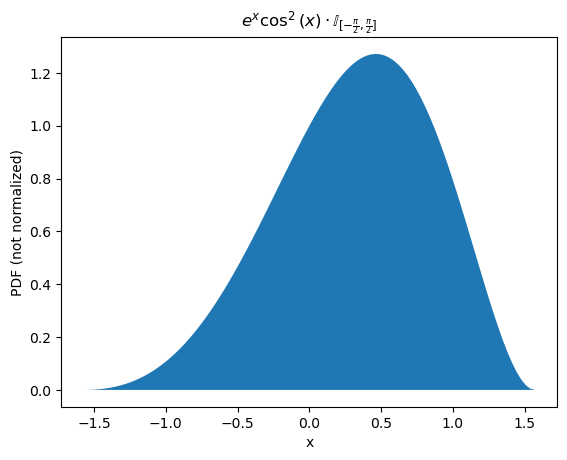

In [6]:
fig = plt.figure()

x = np.linspace(-np.pi/2, np.pi/2, 100)
density = np.exp(x) * np.cos(x) ** 2 # not normalized density!
plt.fill_between(x, 0, density)
plt.ylabel('PDF (not normalized)')
plt.xlabel('x')
plt.title(r'$e^x \cos^2(x) \cdot \mathbb{I}_{[-\frac{\pi}{2}, \frac{\pi}{2}]}$')

plt.show()

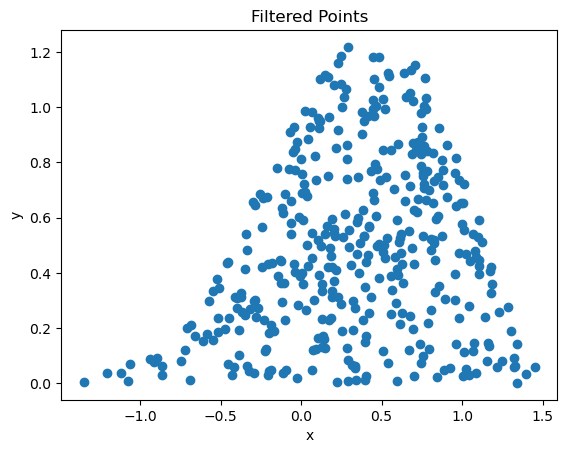

In [7]:
# Parameters
N = 1000
x_start, x_end = -np.pi / 2, np.pi / 2
y_start, y_end = 0, 1.5

# Random points in the rectangle
x = np.random.uniform(x_start, x_end, N)
y = np.random.uniform(y_start, y_end, N)

# Filtering points
condition = np.exp(x) * np.cos(x) ** 2 > y
filtered_points = np.column_stack((x[condition], y[condition]))

plt.scatter(filtered_points[:, 0], filtered_points[:, 1])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Filtered Points')
plt.show()

## Coordinate transformation method

The accept-reject method may in some cases be inefficient and require too many sample points. An alternative is to try to find a coordinate transformation that converts a simple area (from which it is easy to sample, for example, a unit square) into the required area, but preserves the area ratio (why?).

### Problem 7
Model and depict a sample of 500 points uniformly distributed within a given triangle without using a selection method.

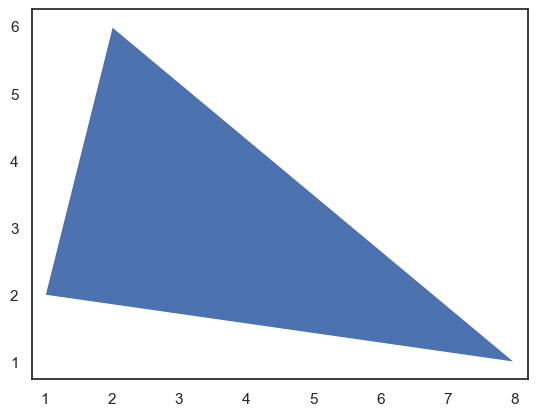

In [13]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

fig = plt.figure()

polygon = Polygon(xy=np.array([[1, 2], [2, 6], [8, 1]]), closed=True)
plt.gca().add_collection(PatchCollection([polygon]))
plt.axis('equal')
plt.show()

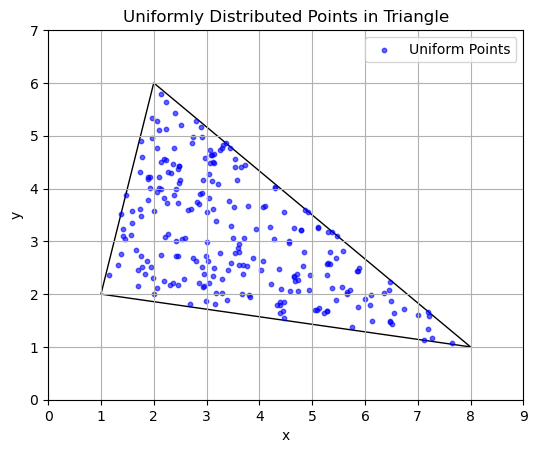

In [9]:

# Vertices
A = np.array([1, 2])
B = np.array([2, 6])
C = np.array([8, 1])
vertices = np.array([A, B, C])

N = 500
u = np.random.uniform(0, 1, N)
v = np.random.uniform(0, 1, N)

# Filter points to ensure u + v <= 1
mask = u + v <= 1
u = u[mask]
v = v[mask]

# Barycentric coordinates
points = A + u[:, np.newaxis] * (B - A) + v[:, np.newaxis] * (C - A)

# Plotting triangle
fig, ax = plt.subplots()
polygon = Polygon(vertices, closed=True, edgecolor='black', facecolor='none')
ax.add_patch(polygon)

# Plotting generated points
ax.scatter(points[:, 0], points[:, 1], s=10, color='blue', alpha=0.6, label='Uniform Points')

ax.set_xlim(0, 9)
ax.set_ylim(0, 7)
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Uniformly Distributed Points in Triangle')
ax.legend()
plt.grid(True)
plt.show()

### Problem 8
Model without using the selection method a sample of $500$ points uniformly distributed inside the unit circle. Picture the obtained points. Do they really fill the circle uniformly?

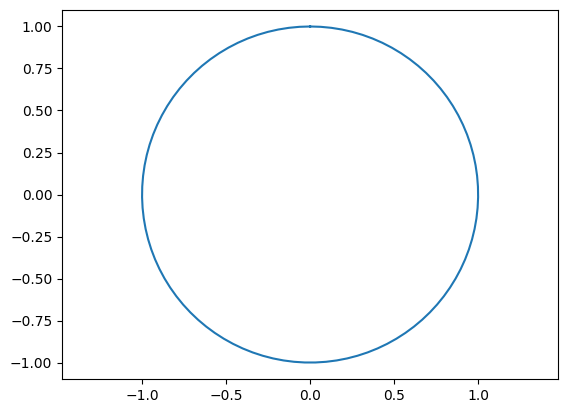

In [ ]:
fig = plt.figure()

t = np.linspace(0, 2*np.pi, 100)
plt.plot(np.sin(t), np.cos(t))
plt.axis('equal')
plt.show()

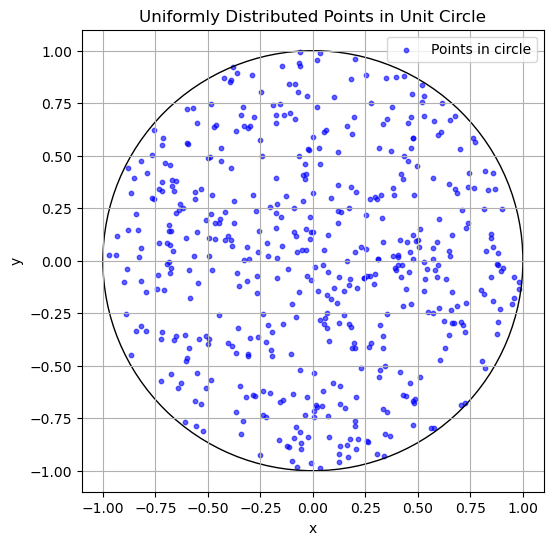

In [10]:
N = 500
u = np.random.uniform(0, 1, N)
v = np.random.uniform(0, 1, N)

# Polar coordinates
r = np.sqrt(u)  
phi = 2 * np.pi * v 

# Cartesian coordinates
x = r * np.cos(phi)
y = r * np.sin(phi)

plt.figure(figsize=(6, 6))
plt.scatter(x, y, s=10, color='blue', alpha=0.6, label='Points in circle')
circle = plt.Circle((0, 0), 1, edgecolor='black', facecolor='none')
plt.gca().add_patch(circle)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.gca().set_aspect('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Uniformly Distributed Points in Unit Circle')
plt.legend()
plt.grid(True)
plt.show()

### Problem 9
Prove (orally) that the following algorithm (**Box-Muller algorithm**, https://en.wikipedia.org/wiki/Box%E2%80%93Muller_transform) generates a sample of independent $\mathcal{N}(0,1)$ random variables. Modify the method to exclude calls of trigonometric functions `np.sin` and `np.cos`. Using the modified method, simulate a sample size of $1000$ from a $2D$ Gaussian distribution with mean $\mu$ and covariance matrix $\Sigma$, where
$$\mu = \begin{pmatrix} 4 \\ 7 \end{pmatrix}^T, \quad \Sigma = \begin{pmatrix} 20 & -4 \\ -4 & 40 \end{pmatrix}.$$
Construct a 2D histogram of the resulting distribution. Compare the sample mean and covariance matrix with the exact values.

Sample mean:
 [3.84159307 6.70177531]
Exact mean:
 [4 7]
Sample covariance:
 [[20.52290061 -4.32345248]
 [-4.32345248 39.48869246]]
Exact covariance:
 [[20 -4]
 [-4 40]]


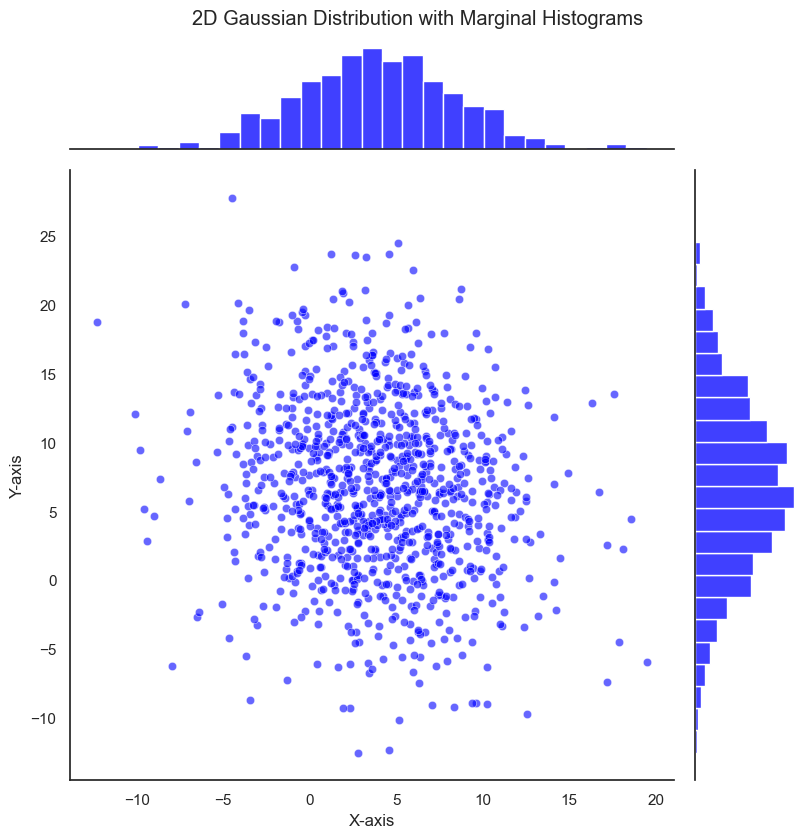

In [11]:
import seaborn as sns
# Marsaglia polar method
def marsaglia_polar(n):
    samples = []
    while len(samples) < n:
        u1, u2 = np.random.uniform(-1, 1, 2)
        s = u1**2 + u2**2
        if s < 1:
            z1 = u1 * np.sqrt(-2 * np.log(s) / s)
            z2 = u2 * np.sqrt(-2 * np.log(s) / s)
            samples.append((z1, z2))
    return np.array(samples)

n = 1000
samples = marsaglia_polar(n)
mu = np.array([4, 7])
Sigma = np.array([[20, -4], [-4, 40]])
L = np.linalg.cholesky(Sigma)
transformed_samples = mu + np.dot(samples, L.T)

#  Joint plot with marginal histograms
sns.set(style="white", color_codes=True)
joint_plot = sns.jointplot(x=transformed_samples[:, 0], y=transformed_samples[:, 1], 
                           kind='scatter', color='blue', height=8, alpha=0.6)

joint_plot.set_axis_labels('X-axis', 'Y-axis')
joint_plot.fig.suptitle('2D Gaussian Distribution with Marginal Histograms', y=1.02)


# Sample mean and covariance and their exact values
sample_mean = np.mean(transformed_samples, axis=0)
sample_cov = np.cov(transformed_samples, rowvar=False)

print("Sample mean:\n", sample_mean)
print("Exact mean:\n", mu)
print("Sample covariance:\n", sample_cov)
print("Exact covariance:\n", Sigma)

### Problem 10*

Implement a method of generating a random partition of an n-element set into subsets. Use it to estimate the expected number of subsets in a random partition of a set of 100 elements.

Hint 1: Ширяев, Вероятность, т1, задача 2 к параграфу 1.

Hint 2: http://djalil.chafai.net/blog/2012/05/03/generating-uniform-random-partitions/

In [12]:
def len_partition(n):
    subsets = [] 
    for element in range(1, n + 1):
        if not subsets:  # If no subsets, make the first one
            subsets.append([element])
        else:
            # add the element to an existing subset or create a new
            prob_new_subset = 1 / (len(subsets) + 1)
            if np.random.rand() < prob_new_subset:
                subsets.append([element])
            else:
                subset_index = np.random.randint(0, len(subsets))
                subsets[subset_index].append(element)
    return len(subsets)  # number of subsets

def estimate_expected_subsets(n, num_simulations=10000):
    total_subsets = 0
    for _ in range(num_simulations):
        total_subsets += len_partition(n)
    return total_subsets / num_simulations

n = 100
expected_subsets = estimate_expected_subsets(n)
print(f"Estimated expected number of subsets for n = {n}: {expected_subsets}")

Estimated expected number of subsets for n = 100: 13.4619
